In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone


warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("diabetic_data.csv")
print("Shape:", df.shape)

# Target encoding
target = "readmitted"
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x == "<30" else 0)
print(y.value_counts(normalize=True))
df.head()

C:\Users\user\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape: (101766, 50)
readmitted
0    0.888401
1    0.111599
Name: proportion, dtype: float64


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [2]:
df.isnull().sum()
df.dropna(inplace=True)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
162,2521974,80499960,Caucasian,Male,[80-90),?,6,3,7,5,...,No,No,No,No,No,No,No,No,No,<30
192,2595612,89193870,Caucasian,Female,[40-50),?,6,1,7,2,...,No,No,No,No,No,No,No,No,No,>30
460,4084524,76959585,AfricanAmerican,Female,[70-80),?,6,1,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,>30
593,4804968,114960726,Caucasian,Female,[50-60),?,6,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,NO
696,5319174,87847776,Other,Male,[70-80),?,6,6,7,11,...,No,No,No,No,No,No,No,No,Yes,NO


Categorical: 36 | Numeric: 13
Train size: (81412, 50) Test size: (20354, 50)
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18187
           1       0.80      0.00      0.00      2167

    accuracy                           0.89     20354
   macro avg       0.85      0.50      0.47     20354
weighted avg       0.88      0.89      0.84     20354



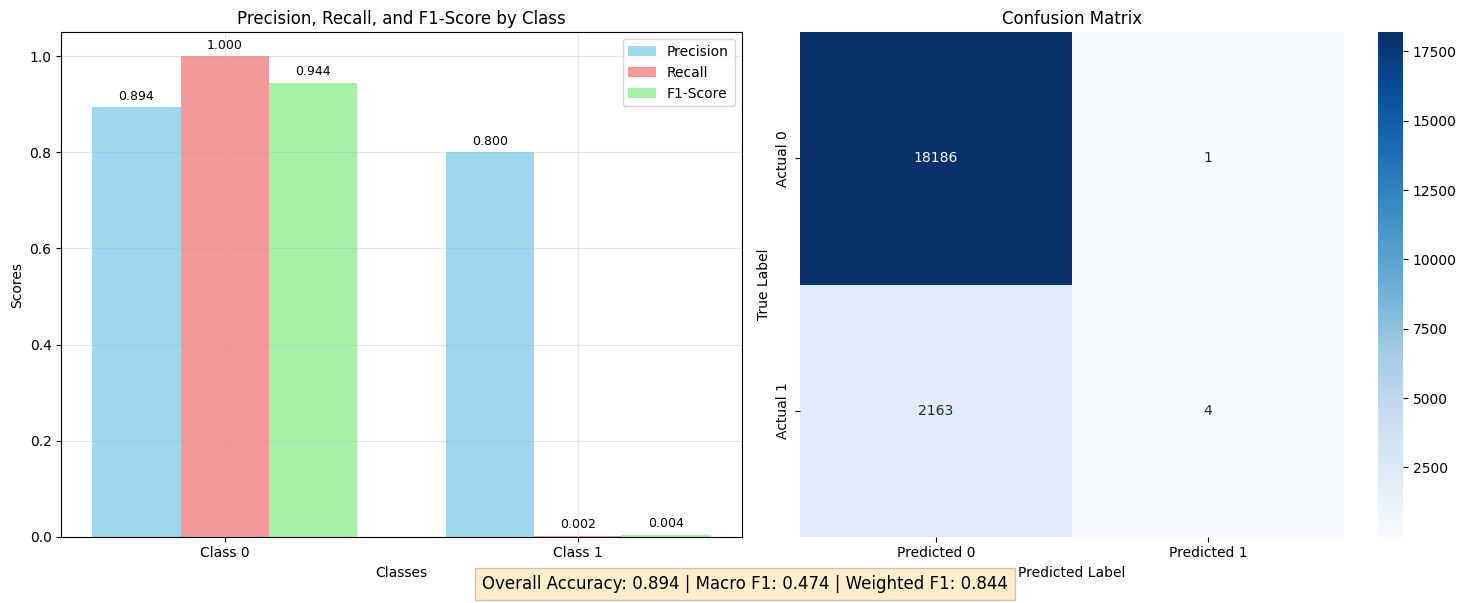

KEY METRICS SUMMARY
Accuracy: 0.8937
Precision (Class 1): 0.8000
Recall (Class 1): 0.0018
F1-Score (Class 1): 0.0037
Macro Avg F1: 0.4738
Weighted Avg F1: 0.8437


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
print(f"Categorical: {len(categorical_cols)} | Numeric: {len(numeric_cols)}")

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Temporal split to avoid leakage when 'admission_type_id' exists
if "admission_type_id" in df.columns:
    X["admission_order"] = np.arange(len(X))
    sorted_idx = X["admission_order"].sort_values().index
    X_sorted, y_sorted = X.loc[sorted_idx], y.loc[sorted_idx]
    split_idx = int(0.8 * len(X_sorted))
    X_train, X_test = X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:]
    y_train, y_test = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Create and train the pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

# Predictions and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Generate classification report
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Metrics by class
classes = ['Class 0', 'Class 1']
precision_scores = [report['0']['precision'], report['1']['precision']]
recall_scores = [report['0']['recall'], report['1']['recall']]
f1_scores = [report['0']['f1-score'], report['1']['f1-score']]
x = np.arange(len(classes))
width = 0.25

ax1.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='skyblue')
ax1.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightcoral')
ax1.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightgreen')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Scores')
ax1.set_title('Precision, Recall, and F1-Score by Class')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (prec, rec, f1) in enumerate(zip(precision_scores, recall_scores, f1_scores)):
    ax1.text(i - width, prec + 0.01, f'{prec:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i, rec + 0.01, f'{rec:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
ax2.set_title('Confusion Matrix')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# Overall metrics summary
accuracy = report['accuracy']
macro_f1 = report['macro avg']['f1-score']
weighted_f1 = report['weighted avg']['f1-score']
plt.figtext(0.5, 0.01, 
            f"Overall Accuracy: {accuracy:.3f} | Macro F1: {macro_f1:.3f} | Weighted F1: {weighted_f1:.3f}",
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()

# Print key metrics
print("=" * 60)
print("KEY METRICS SUMMARY")
print("=" * 60)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Class 1): {report['1']['precision']:.4f}")
print(f"Recall (Class 1): {report['1']['recall']:.4f}")
print(f"F1-Score (Class 1): {report['1']['f1-score']:.4f}")
print(f"Macro Avg F1: {macro_f1:.4f}")
print(f"Weighted Avg F1: {weighted_f1:.4f}")


Running feature selection once with RandomForest...
Selected 347 features: ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient']...


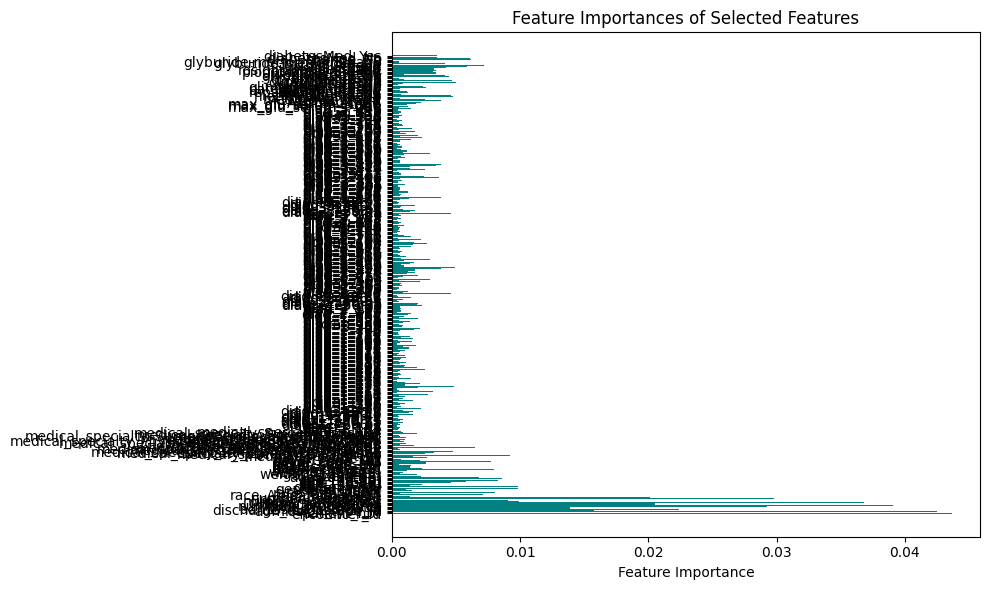

In [4]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

print("Running feature selection once with RandomForest...")

# Define the RandomForest model for feature selection
fs_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Create pipeline with preprocessing and feature selector
selector_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("selector", SelectFromModel(fs_model))
])

# Fit the pipeline on training data
selector_pipeline.fit(X_train, y_train)

# Transform training and test data based on selected features
X_train_fs = selector_pipeline.transform(X_train)
X_test_fs = selector_pipeline.transform(X_test)

# Retrieve mask of selected features
mask = selector_pipeline.named_steps["selector"].get_support()

# Get all feature names after preprocessing (numeric + encoded categorical)
feature_names_all = numeric_cols + list(
    selector_pipeline.named_steps["preprocessor"]
        .transformers_[1][1]["encoder"]
        .get_feature_names_out(categorical_cols)
)

# Features selected by the model
selected_features = [f for f, m in zip(feature_names_all, mask) if m]
print(f"Selected {len(selected_features)} features: {selected_features[:10]}...")

# Plot feature importances from the RandomForest model
importances = selector_pipeline.named_steps["selector"].estimator_.feature_importances_
selected_importances = importances[mask]

plt.figure(figsize=(10, 6))
plt.barh(selected_features, selected_importances, color='teal')
plt.xlabel("Feature Importance")
plt.title("Feature Importances of Selected Features")
plt.tight_layout()
plt.show()



Training LogisticRegression...
LogisticRegression: Acc=0.894, AUC=0.643, Brier=0.092

Training RandomForest...
RandomForest: Acc=0.894, AUC=0.627, Brier=0.093

Training XGBoost...
XGBoost: Acc=0.894, AUC=0.650, Brier=0.093

Training SVM...
SVM: Acc=0.894, AUC=0.595, Brier=0.094


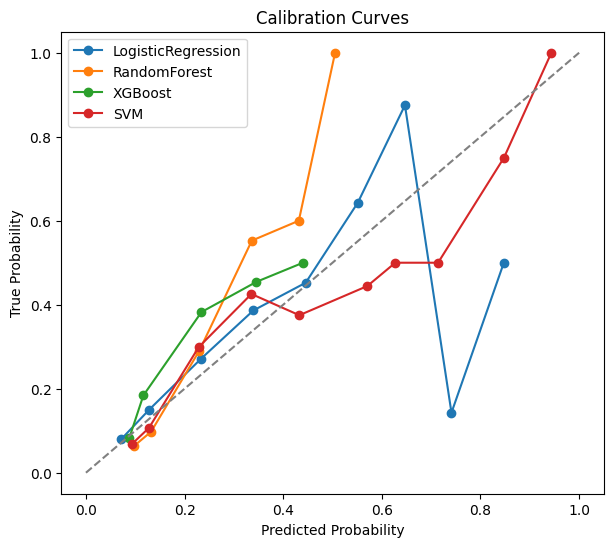


=== Model Comparison ===
LogisticRegression -> {'Accuracy': 0.8940748747175002, 'ROC-AUC': 0.6430673603200753, 'Brier': 0.09201538811586203, 'y_prob': array([0.06536457, 0.08779783, 0.0476668 , ..., 0.06142273, 0.09092257,
       0.06904257], shape=(20354,))}
RandomForest -> {'Accuracy': 0.8936327011889554, 'ROC-AUC': 0.6265600725113141, 'Brier': 0.09337423247344089, 'y_prob': array([0.13694941, 0.12164276, 0.11802705, ..., 0.11744956, 0.17010836,
       0.13704174], shape=(20354,))}
XGBoost -> {'Accuracy': 0.8935344404048344, 'ROC-AUC': 0.6503338680455766, 'Brier': 0.09343592925166805, 'y_prob': array([0.08506228, 0.082962  , 0.08421397, ..., 0.08913427, 0.09342743,
       0.08497706], shape=(20354,))}
SVM -> {'Accuracy': 0.8938783531492581, 'ROC-AUC': 0.5946345646820606, 'Brier': 0.09375428810045124, 'y_prob': array([0.12143204, 0.11489012, 0.09210216, ..., 0.13150864, 0.12075997,
       0.13349586], shape=(20354,))}


In [5]:
base_models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric="logloss", use_label_encoder=False, n_jobs=-1),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42)  # slower
}

results = {}
plt.figure(figsize=(7, 6))

for name, model in base_models.items():
    print(f"\nTraining {name}...")
    calibrated = CalibratedClassifierCV(clone(model), method="sigmoid", cv=3, n_jobs=1)

    if name == "SVM":
        # Use 30% of training data for SVM to save time
        n_samples = X_train_fs.shape[0]
        sample_idx = np.random.choice(n_samples, size=int(0.3*n_samples), replace=False)
        calibrated.fit(X_train_fs[sample_idx], y_train.iloc[sample_idx])
    else:
        calibrated.fit(X_train_fs, y_train)

    y_pred = calibrated.predict(X_test_fs)
    y_prob = calibrated.predict_proba(X_test_fs)[:,1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)

    # Save probabilities for DCA
    results[name] = {
        "Accuracy": acc,
        "ROC-AUC": auc,
        "Brier": brier,
        "y_prob": y_prob
    }

    print(f"{name}: Acc={acc:.3f}, AUC={auc:.3f}, Brier={brier:.3f}")

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker="o", label=name)

plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curves")
plt.legend()
plt.show()

print("\n=== Model Comparison ===")
for model, scores in results.items():
    print(f"{model} -> {scores}")

Computing SHAP values for XGBoost...


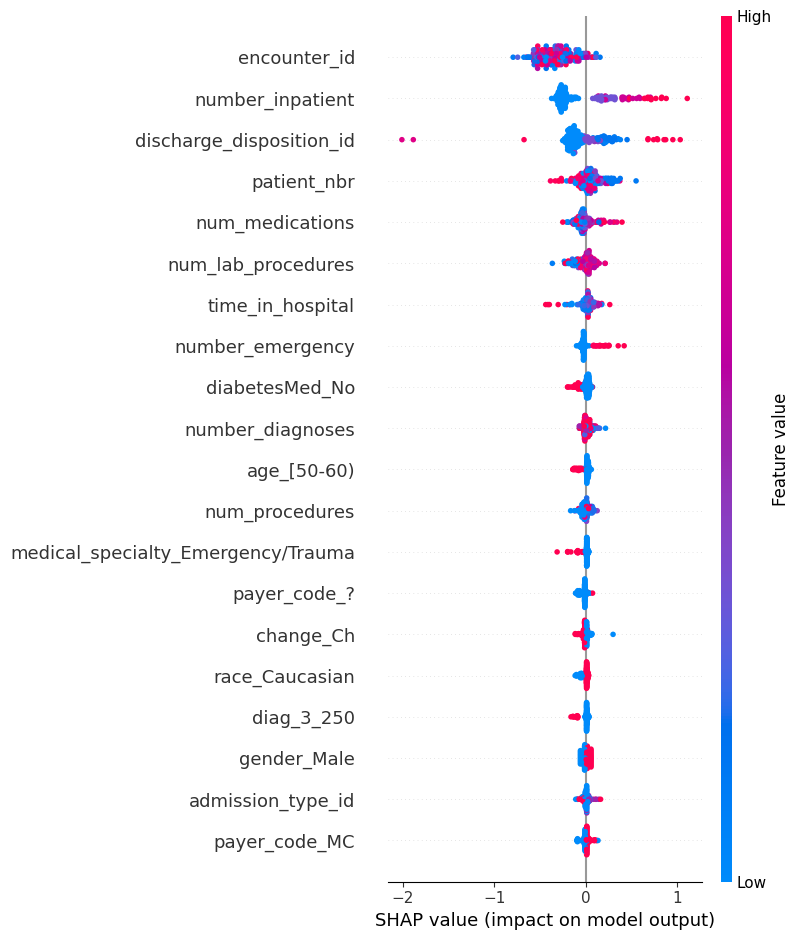

In [6]:
print("Computing SHAP values for XGBoost...")

# Convert sparse matrices to dense
X_train_dense = X_train_fs.toarray() if hasattr(X_train_fs, "toarray") else X_train_fs
X_test_dense = X_test_fs.toarray() if hasattr(X_test_fs, "toarray") else X_test_fs

xgb = XGBClassifier(n_estimators=100, eval_metric="logloss", use_label_encoder=False, n_jobs=-1)
xgb.fit(X_train_dense, y_train)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_test_dense[:200])

shap.summary_plot(shap_values, features=X_test_dense[:200], feature_names=selected_features, show=True)

In [7]:
# Compute mean absolute SHAP values
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": selected_features,
    "MeanAbsSHAP": shap_abs_mean
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="MeanAbsSHAP", ascending=False).reset_index(drop=True)

# Add impact direction
mean_shap = shap_values.values.mean(axis=0)
feature_importance_df["ImpactDirection"] = np.where(mean_shap > 0, "↑ Readmission Risk",
                                                   np.where(mean_shap < 0, "↓ Readmission Risk", "Neutral"))

# Display top 15 features
print("Top 15 Clinically Relevant Features Based on SHAP:")
display(feature_importance_df.head(15))


Top 15 Clinically Relevant Features Based on SHAP:


,Feature,MeanAbsSHAP,ImpactDirection
0,encounter_id,0.332084,↓ Readmission Risk
1,number_inpatient,0.289246,↑ Readmission Risk
2,discharge_disposition_id,0.198804,↑ Readmission Risk
3,patient_nbr,0.110353,↓ Readmission Risk
4,num_medications,0.068828,↑ Readmission Risk
5,num_lab_procedures,0.065887,↑ Readmission Risk
6,time_in_hospital,0.052474,↓ Readmission Risk
7,number_emergency,0.047591,↓ Readmission Risk
8,diabetesMed_No,0.034890,↓ Readmission Risk
9,number_diagnoses,0.031916,↑ Readmission Risk
